# Experiments with pysdot

First import the relevant python libraries.

In [1]:
#imports
from pysdot.domain_types import ConvexPolyhedraAssembly
#from pysdot.domain_types import ScaledImage
from pysdot import OptimalTransport
from pysdot import PowerDiagram
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import time as tm

## Computing a power diagram

### Set up the domain

In [2]:
L=2; # Cube dimensions

dm=ConvexPolyhedraAssembly(); # Create a polyhedral assembly
dm.add_box([0,0,0],[L,L,L]); # Add the box dimensions
dm.measure()

8.0

### Set up random seed locations and compute the Voronoi diagram

In [3]:
st=tm.time();
N=10000; # Specify the number of grains
x=L*np.random.rand(N,3); # Random seed locations in the cube
w=0*np.ones(N);
pd=PowerDiagram(positions=x,weights=w,domain=dm);
en=tm.time();
print('Elapsed time {}'.format(en-st))

Elapsed time 0.0005803108215332031


In [4]:
# Store the volumes in an array
vols=pd.integrals();

# Save the results in a .vtk file
filename="results.vtk";
pd.display_vtk(filename);

In [5]:
# Read the data
grid=pv.read(filename)
# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols=vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']=cell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
#grid.plot(scalars='vols',jupyter_backend='static',background='white')
plotter = pv.Plotter(window_size=[800,800],notebook=True)
plotter.add_mesh(grid)
plotter.show()

# Add a headlight
light=pv.Light(light_type='headlight')
plotter.add_light(light)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


## Solving OT problem for given grain volume distributions


### Create distribution of target volumes

In [6]:
N=1000;

x=L*np.random.rand(N,3); # Random seed locations in the cube
w=0*np.ones(N);

ln_mean=1; # mean of the distribution
std_dev=0.35; # standard deviation of the distribution
sigma=np.sqrt((np.log(1+(std_dev/ln_mean)**2))); # log-normal parameter sigma
mu=-0.5*sigma**2+np.log(ln_mean); # log-normal parameter mu

# Draw the radii from the log-normal distribution
radii=np.random.lognormal(mu,sigma,N);
target_vols=radii**3

# Log-normal target_vols
target_vols=L**3*target_vols/np.sum(target_vols)

# Equal target volumes
#target_vols=L**3*np.ones(N)/N

if(np.abs(np.sum(target_vols)-L**3)<2*np.finfo(float).eps):
    print('Target volumes sum to volume of domain to within machine precision')
else:
    print('Target volumes DO NOT sum to volume of domain error {}'.format(np.sum(target_vols)-L**3))
    


Target volumes sum to volume of domain to within machine precision


### Solve OT problem

In [8]:
err_tol=1e-3;
st=tm.time()
ot=OptimalTransport(positions=x,weights=w,masses=target_vols,domain=dm,obj_max_dw=err_tol,verbosity=0)
ot.adjust_weights()
en=tm.time()
print('Elapsed time {}'.format(en-st))


Elapsed time 0.30860209465026855


In [9]:

# Save the powerdiagram from the OT problem
otfilename='results_ot.vtk'
ot.pd.display_vtk(otfilename)

# Store the volumes in an array
otvols=ot.pd.integrals();

In [10]:
# Read the data
otgrid=pv.read(otfilename)
# create cell data that gives the cell volumes, this allows us to colour by cell volumes
otcell_vols=otvols[otgrid.cell_data['num'].astype(int)]
otgrid.cell_data['vols']=otcell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
#grid.plot(scalars='vols',jupyter_backend='static',background='white')
otplotter = pv.Plotter(window_size=[800,800],notebook=True)
otplotter.add_mesh(otgrid)
otplotter.show()

# Add a headlight
otplotter.add_light(light)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


### Check volumes against target_volumes

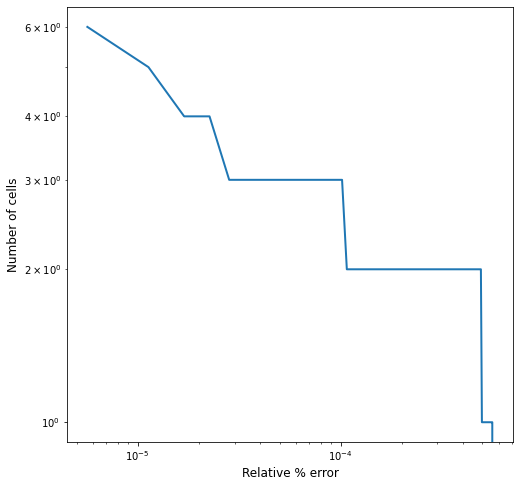

In [11]:
rel_errs=np.abs(target_vols-otvols)/target_vols
abs_errs=np.abs(target_vols-otvols)
counts, bins_counts = np.histogram(rel_errs,100)

pdf = counts
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.figure(figsize=(8,8));
plt.plot(bins_counts[1:], N-cdf, label="CDF",linewidth=2);
plt.yscale('log');
plt.xscale('log');
plt.xlabel('Relative % error',fontsize=12);
plt.ylabel('Number of cells',fontsize=12);
plt.show()

### A function to extract grains with a given index

In [12]:
## Define a function that can extract the grains with a particular index

def getcells(grid,indxs):
    nums=grid.cell_data['num'].astype(int)
    indices=np.array([],dtype=np.int32)
    for idx in indxs:
        tmp=np.where(nums==idx)[0];
        indices=np.concatenate((indices,tmp))
    
    out=grid.extract_cells(indices);
    return out

### Here we extract the ten largest-volume cells and plot them

In [13]:
# The grain index of the m largest volume grains
m=10;
grain_indices=np.argsort(otvols)[-m:]

# Extract these cells
cells=getcells(otgrid,grain_indices)
cellplotter = pv.Plotter(window_size=[800,800],notebook=True)
cellplotter.add_mesh(cells)
cellplotter.show()

# Add a headlight
cellplotter.add_light(light)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.
